In [1]:
# Description: Plot Figure 1 (Maps with the locations of all surface currents).
# Author:      André Palóczy
# E-mail:      paloczy@gmail.com
# Date:        May/2023

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from xarray import open_dataset
from gsw import f as fcor
from gsw import grav
from cmocean.cm import amp
from ap_tools.utils import point_in_poly, lon180to360, bbox2ij
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.feature import LAND

proj = ccrs.PlateCarree()
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()

In [3]:
def mdt2uv(lon, lat, mdt):
    deglat2m = 1852*60
    dy = np.gradient(lat, axis=0)*deglat2m
    dx = np.gradient(lon, axis=1)*np.cos(lat*np.pi/180)*deglat2m
    dmdtdy, dmdtdx = np.gradient(mdt)
    dmdtdy, dmdtdx = dmdtdy/dy, dmdtdx/dx
    ugfac = grav(lat, 0)/fcor(lat)
    u = -ugfac*dmdtdy
    v = +ugfac*dmdtdx

    return u, v


def get_DPfrontsll(f, bbDP):
    lonl, lonr, lats, latn = bbDP
    dsf = open_dataset(f)
    loncSACCF, latcSACCF = dsf["LonSACCF"].values, dsf["LatSACCF"].values
    loncPF, latcPF = dsf["LonPF"].values, dsf["LatPF"].values
    loncSAF, latcSAF = dsf["LonSAF"].values, dsf["LatSAF"].values
    bb = np.logical_and(np.logical_and(loncSACCF>=lonl, loncSACCF<=lonr), np.logical_and(latcSACCF>=lats, latcSACCF<=latn))
    llSACCF = (loncSACCF[bb], latcSACCF[bb])
    bb = np.logical_and(np.logical_and(loncPF>=lonl, loncPF<=lonr), np.logical_and(latcPF>=lats, latcPF<=latn))
    llPF = (loncPF[bb], latcPF[bb])
    bb = np.logical_and(np.logical_and(loncSAF>=lonl, loncSAF<=lonr), np.logical_and(latcSAF>=lats, latcSAF<=latn))
    llSAF = (loncSAF[bb], latcSAF[bb])

    return llSAF, llPF, llSACCF


def pltbox(ax, xl, xr, yd, yu, color="r", linewidth=1.5, linestyle="solid", zorder=11):
    kw = dict(color=color, linewidth=linewidth, linestyle=linestyle, zorder=zorder)
    ax.plot([xl, xr], [yd, yd], **kw)
    ax.plot([xr, xr], [yd, yu], **kw)
    ax.plot([xl, xr], [yu, yu], **kw)
    ax.plot([xl, xl], [yd, yu], **kw)

In [4]:
figsize = (10, 8)
f_climfronts = "../../data/misc/ACC_fronts_PHI19.nc"

# Drake Passage panel parameters.
xminDP, xmaxDP = -80.0, -41.0
yminDP, ymaxDP = -65.0, -54.5

# Gulf Stream panel parameters.
xminGS, xmaxGS = -82, -64
yminGS, ymaxGS = 30, 40

head_deriv = "../../data/derived/"
fnames = ["AgulhasCurrent", "EAC29S", "BrazilCurrent29S", "KuroshioCurrent25N", "KuroshioCurrent28p5N"]
fnamesGS = ["GulfStream33N", "GulfStream34N", "GulfStream36N", "GulfStream37N", "GulfStream38N"]
fnames_synop = ["BC", "GC", "ACnorth", "ACsouth"]

In [5]:
# Get MDT and surface geostrophic speed.
nsub = 2 # Need to subset just to enable rendering of panel (a).

dsmdt = open_dataset("../../data/DTU15/DTU15MDT_2min.mdt.nc", chunks="auto")
lon, lat, mdt = dsmdt["lon"].values, dsmdt["lat"].values, dsmdt["mdt"].values
lonn, latt = np.meshgrid(lon, lat)
u, v = mdt2uv(lonn, latt, mdt)
Ug = np.sqrt(u**2 + v**2)
Ug = Ug[::nsub, ::nsub]
lon = lon[::nsub]
lat = lat[::nsub]
lonn = lonn[::nsub, ::nsub]
latt = latt[::nsub, ::nsub]
mdt = mdt[::nsub, ::nsub]

Ugmax = 70     # [cm/s]
Ugthresh = 1.0 # [m/s]
eqband = 2

Ug[Ug>Ugthresh] = np.nan
fequator = np.abs(lat)<eqband
Ug[fequator] = np.nan
xmi, xma = -180, 180
ymi, yma = -90, 90
numtks = 10
xtks = np.linspace(xmi, xma, num=numtks)
ytks = np.linspace(ymi, yma, num=numtks)
nmdtcc = 30
nmdtcc2 = 50

In [6]:
# Get bathymetry.
dl = 2

fbathymetry = "../../data/srtm15p/SRTM15_V2.5.5.nc"
isobs = [100, 1000, 2000, 4000]
dstopo = open_dataset(fbathymetry).sel(lon=slice(xminDP-dl, xmaxDP+dl), lat=slice(yminDP-dl, ymaxDP+dl))
xt, yt = np.meshgrid(dstopo["lon"].values, dstopo["lat"].values)
zt = -dstopo["z"].values

In [7]:
# Get ACC front crossing transects.
head = "../../data/derived/"
dsSAF = open_dataset(head + "ustream_SAFjet_LMG.nc")
dsPF = open_dataset(head + "ustream_PFjet_LMG.nc")
dsSACCF = open_dataset(head + "ustream_SACCFjet_LMG.nc")

### Plot the global MDT map with the locations of all surface currents.

/home/andrpalo/Dropbox/code/ap_tools/utils.py:586: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lon, lat, bbox = map(np.array, (lon, lat, bbox))


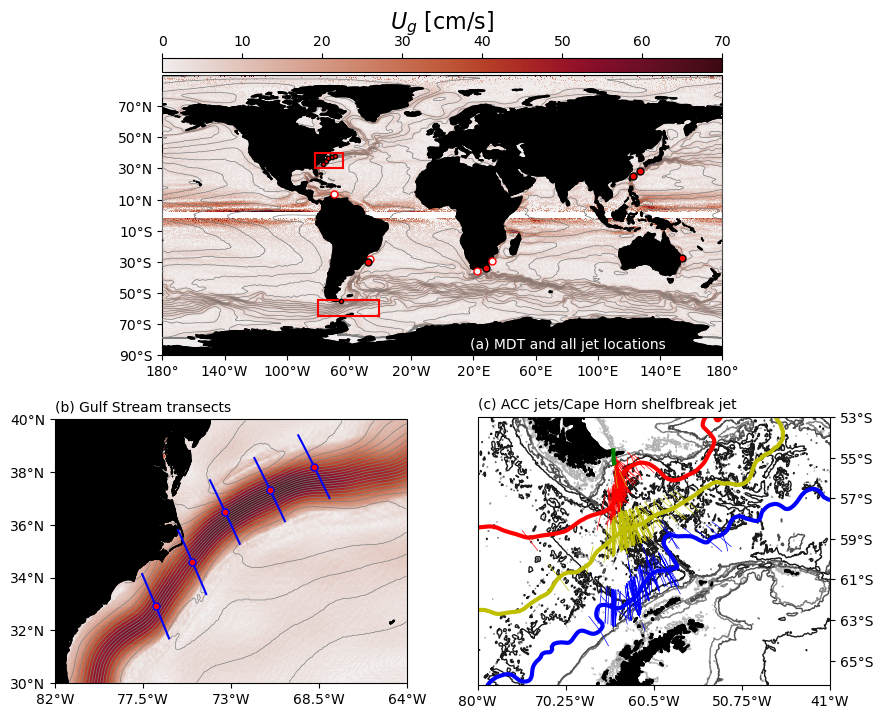

In [8]:
fig = plt.figure(figsize=figsize)
axshp = (2, 2)
ax1 = plt.subplot2grid(axshp, (0, 0), colspan=2, projection=proj)
ax2 = plt.subplot2grid(axshp, (1, 1), colspan=1, projection=proj)
ax3 = plt.subplot2grid(axshp, (1, 0), colspan=1, projection=proj)

# (a) Global MDT map with along-track transect locations.
cs = ax1.pcolormesh(lon, lat, Ug*100, vmax=Ugmax, cmap=amp)
ax1.contour(lon, lat, mdt, levels=nmdtcc, colors="gray", linestyles="solid", linewidths=0.5, zorder=7)
ax1.coastlines()
ax1.add_feature(LAND, zorder=9, color="k")

for f in fnames:
    d = np.load(head_deriv + f + ".npz")
    ax1.plot(d["lon"], d["lat"], "k", zorder=11)
    ax1.plot(d["lon0"], d["lat0"], marker="o", ms=5, mfc="r", mec="k", zorder=11)

for f in fnamesGS:
    d = np.load(head_deriv + f + ".npz")
    ax1.plot(d["lon"], d["lat"], "k", zorder=11)
    ax1.plot(d["lon0"], d["lat0"], marker="o", ms=3, mfc="r", mec="k", zorder=11)

for f in fnames_synop:
    d = np.load(head_deriv + f + ".npz")
    ax1.plot(d["lon"], d["lat"], "k", zorder=10)
    ax1.plot(d["lon0"], d["lat0"], marker="o", ms=5, mfc="w", mec="r", zorder=10)

# Add boxes for insets in panels (b, c, d).
pltbox(ax1, xminDP, xmaxDP, yminDP, ymaxDP)
pltbox(ax1, xminGS, xmaxGS, yminGS, ymaxGS)

ax2.set_extent((xminDP, xmaxDP, yminDP, ymaxDP))
ax3.set_extent((xminGS, xmaxGS, yminGS, ymaxGS))

ax1.set_xticks(xtks, crs=proj)
ax1.set_yticks(ytks, crs=proj)
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

cax = ax1.inset_axes([0, 1.01, 1, 0.05])
cb = fig.colorbar(cs, cax=cax, orientation="horizontal")
cb.set_label(r"$U_g$ [cm/s]", fontsize=16)
cb.ax.xaxis.set_ticks_position("top"); cb.ax.xaxis.set_label_position("top")

# (b) Zoom on Drake Passage with mean location of the fronts.
# Overlay climatological ACC front positions from CMEMS MDT.
bbDP = (xminDP-dl, xmaxDP+dl, yminDP-dl, ymaxDP+dl)
llSAF1, llPF1, llSACCF1 = get_DPfrontsll(f_climfronts, bbDP)
ax2.plot(llSAF1[0], llSAF1[1], "r", linewidth=3)
ax2.plot(llPF1[0], llPF1[1], "y", linewidth=3)
ax2.plot(llSACCF1[0], llSACCF1[1], "b", linewidth=3)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

# Plot bathymetry.
bcols = [[0.7]*3, [0.5]*3, [0.3]*3, [0.1]*3]
ax2.contour(xt, yt, zt, levels=isobs, colors=bcols, linewidths=1, zorder=1)

ax2.coastlines()
ax2.add_feature(LAND, zorder=9, color="k")

d = np.load(head_deriv + "LMGshfbrk.npz")
ax2.plot(d["lon"], d["lat"], color="g", linewidth=3.0, linestyle="solid", zorder=11)
#ax2.plot(d["lon0"], d["lat0"], marker="o", ms=4, mfc="r", mec="r", zorder=12)
ax1.plot(d["lon0"], d["lat0"], marker="o", ms=3, mfc="r", mec="k", zorder=12)

numtksx = 5
xtks = np.linspace(round(xminDP), round(xmaxDP), num=numtksx)
ytks = np.arange(yminDP, ymaxDP + 2, 2)
ax2.set_xticks(xtks, crs=proj)
ax2.set_yticks(ytks, crs=proj)
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)

# (c) Zoom on the Gulf Stream transects.
lon, lat, mdt = dsmdt["lon"].values, dsmdt["lat"].values, dsmdt["mdt"].values
lonn, latt = np.meshgrid(lon, lat)

bb = [lon180to360(xminGS), lon180to360(xmaxGS), yminGS, ymaxGS]
il, ir, jl, jr = bbox2ij(lonn, latt, bbox=bb)
mdt = mdt[jl:jr, il:ir]
u, v = u[jl:jr, il:ir], v[jl:jr, il:ir]
lonn, latt = lonn[jl:jr, il:ir], latt[jl:jr, il:ir]

Ug = np.sqrt(u**2 + v**2)
Ug[Ug>Ugthresh] = np.nan

cs = ax3.pcolormesh(lonn, latt, Ug*100, vmax=Ugmax, cmap=amp)
ax3.contour(lonn, latt, mdt, levels=nmdtcc2, colors="gray", linestyles="solid", linewidths=0.5, zorder=7)
ax3.coastlines()
ax3.add_feature(LAND, zorder=9, color="k")

for f in fnamesGS:
    d = np.load(head_deriv + f + ".npz")
    ax3.plot(d["lon"], d["lat"], color="b", linewidth=1.5, linestyle="solid", zorder=11)
    ax3.plot(d["lon0"], d["lat0"], marker="o", ms=5, mfc="r", mec="b", zorder=12)

for n in range(dsSAF.dims["t"]):
    dsn = dsSAF.isel(dict(t=n))
    ax2.plot(dsn["lon"].values, dsn["lat"].values, "r", linewidth=0.5)

for n in range(dsPF.dims["t"]):
    dsn = dsPF.isel(dict(t=n))
    ax2.plot(dsn["lon"].values, dsn["lat"].values, "y", linewidth=0.5)

for n in range(dsSACCF.dims["t"]):
    dsn = dsSACCF.isel(dict(t=n))
    ax2.plot(dsn["lon"].values, dsn["lat"].values, "b", linewidth=0.5)

numtks = 5
xtks = np.linspace(round(xminGS), round(xmaxGS), num=numtks)
ytks = np.arange(yminGS, ymaxGS + 2, 2)
ax3.set_xticks(xtks, crs=proj)
ax3.set_yticks(ytks, crs=proj)
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)

ax1.text(0.55, 0.025, "(a) MDT and all jet locations", color="w", fontsize=10, transform=ax1.transAxes, zorder=20)
ax2.text(0, 1.03, "(c) ACC jets/Cape Horn shelfbreak jet", fontsize=10, transform=ax2.transAxes, zorder=20)
ax3.text(0, 1.03, "(b) Gulf Stream transects", fontsize=10, transform=ax3.transAxes, zorder=20)
ax3.set_aspect(1.35)
ax2.set_aspect(2.25)

In [9]:
fig.savefig("fig01.png", bbox_inches="tight", dpi=150)